In [2]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from IPython.display import Image

import pickle


# Code to run the optimization many times for different data.

The data comes from "make_histograms.ipynb"
the H_new_nolow is wrong, so ignore that for now!

# If you are here to look at the results 
# Run the first cell (above)
# And DO NOT run any cells until told otherwise

In [4]:
H = [5218, 9014, 9533, 9230, 8794, 8812, 8872, 8898, 9618, 10125, 10891, 12268, 12891, 12802, 12729, 13353, 14134, 15019, 16201, 16947, 18037, 19323, 20537, 22323, 24012, 25409, 28191, 30366, 32890, 34426, 36790, 38601, 40332, 42593, 45126, 47601, 50124, 52530, 54542, 56163, 57746, 60094, 62137, 63603, 65386, 67141, 68497, 69616, 69627, 70187, 70855, 72108, 71675, 72995, 72307, 72517, 70935, 70717, 68651, 65840, 63704, 61843, 59496, 57081, 54281, 51536, 48580, 46281, 43560, 41581, 38993, 37045, 35158, 32942, 31089, 29497, 27791, 26355, 25172, 23598, 22207, 20819, 20000, 18855, 17701, 17135, 16204, 15346, 14352, 13993, 13293, 12281, 11671, 10805, 10408, 9692, 9400, 8515, 8068, 7441, 7040, 6529, 6047, 5783, 5308, 4808, 4585, 4157, 3878, 3702, 3306, 3108, 2872, 2718, 2459, 2300, 2093, 2001, 1938, 1758, 1731, 1489, 1437, 1268, 1304, 1135, 1026, 963, 839, 758, 708, 670, 626, 551, 545, 483, 439, 410, 390, 381, 317, 327, 309, 265, 250, 225, 208, 169, 178, 150, 131, 107, 113, 120, 117, 88, 87, 81, 90, 78, 78, 74, 56, 64, 49, 40, 45, 38, 40, 42, 48, 26, 27, 28, 18, 25, 15, 35, 24, 36, 23, 23, 34, 26, 29, 26, 23, 23, 21, 29, 33, 27, 33, 27, 29, 31, 14, 24, 20, 17]
bin_size = 0.1 #[m/s]
max_vel = 20 #[m/s]
#make sure max_vel/bin_size = integer

vel = []
for i in range(int(max_vel/bin_size) + 1):
    vel.append(round(i*bin_size,2))

time_list = []
DT = [60, 30,20,15,10,6]
for dt in DT:
    coef = [-0.04624623,  1.2117235 ]
    poly2d = np.poly1d(coef)
    def acc_fun(v):
        acc = poly2d(v)
        return acc
    def dec_fun(v):
        decel = -2 #m/s^2
        return decel
    u_max = []
    u_min = []
    for v in vel:
        a = acc_fun(v)
        d = dec_fun(v)
        u_max.append(v+a*dt)
        u_min.append(max(0,v+d*dt))
        
    #create U_v = {u, v ∈ V : u ≤ v + a(v) · ∆t} ∩ U_w,     v < w
    induced_sets = []
    old_max = len(vel) + 1 

    for j in range(len(vel)):
        k = len(vel) - j - 1 #going backwards to be able to correct errors due to step-size
        uSet = []
        for i in range(len(vel)):
            if vel[i] <= u_max[k]: # u[k] corresponds to (index of) max(u in U_w), where w = v + |h| 
                if i <= old_max: #This ensures that v_poss <= w_poss if v < w
                    uSet.append(i)
        induced_sets.append(uSet)
        old_max = uSet[-1]

    induced_sets.reverse()

    #Remove unfeasible vel due to deceleration limit
    for i in range(len(u_min)):
        lowest_vel = u_min[i]
        idx = 0
        for j in range(len(u_min)):
            if lowest_vel >= vel[j]:
                idx = j
        induced_sets[i] = induced_sets[i][idx::]


    #Below deletes all unfeasible velocities, this is not great but right now the code cannot deal with it anyways, 
    #so we might as well
    #These exist because at a certain point (v ~ 12 m/s) we have negative (here zero) acceleration due to lack of power (or down-hill slopes)

    #When this happens in the induced_sets we get that u_max = v + 0*dt = v
    #so we delete all sets where u_max[i] = induced_sets[i][-1] = v[i]   
    #in python [-1] denotes last elem in list
    #first: find last index where u_max > v
    to_del = len(vel)+2
    for i in range(len(induced_sets)):
        if induced_sets[i][-1] <= i:
            #print(induced_sets[i][-1],i)
            to_del = min(to_del, i)

    #second: delete all sets above that
    if to_del <= len(vel):
        induced_sets = induced_sets[:to_del]

    #third: append one last set (since we can stay at top speed if we want)
    induced_sets.append(induced_sets[-1])

    # Creates a "truth-table";
    # U_truth[i][j] = 1  if we can reach u[j] from v[i]
    # U_truth[i][j] = 0  else
    U_truth = []
    for i in range(len(induced_sets)):
        v_set = []
        for j in range(len(induced_sets)):
            if j in induced_sets[i]:
                v_set.append(1)
            else:
                v_set.append(0)
        U_truth.append(v_set)
        
        
        
    max_vel_idx = len(U_truth)-1

    vel = vel[0:max_vel_idx]
    H = H[0:max_vel_idx]
    cycle_length = 25 #[min]; length of cycle
    T = int(cycle_length*60/dt) #total number of time steps
    C = 1
    c = sum(H)/T
    H = [x/c for x in H]
    v_0 = vel[0] 
    V_p = vel #rewrite to match notation in other model: average-obj-fun
    T_idx = [t for t in range(T)]         #create a vector with all timesteps t
    Vp_idx = [i for i in range(len(V_p))] #create a vector of idx for velocities 
    I = len(Vp_idx)-1 #Python starts from zero
    ti_pair = [(t,i) for t in T_idx for i in Vp_idx] # if vel[i] <= v_0 + a*min(T-t, t)]
    coeff_ti = {}
    for k in range(len(ti_pair)):
        coeff_ti.update({ti_pair[k]: V_p[ti_pair[k][1]]})  
    M_v = vel[-1]
    c_l = 0.1*dt
    c_p = 0.65
    Ns = 5 #[1] number of stops
    s_lim = 2 #[m/s] all vel below s_lim are considered "stoppage"
    s_av = 13 #[s] average length of stoppage (not used)

    Ts = np.floor(Ns*s_av/dt) #[1] number of time-steps that should be "stoppage" (not used)
    sigma_s = np.floor(Ts/10) # [1] lax in Ts (p/m 10%) (taken out of my ass) (not used)

    #Create set for "stoppage"-velocities
    V_s = []
    Vs_idx = []
    for i in range(len(V_p)):
        if V_p[i] < s_lim:
            V_s.append(V_p[i])
            Vs_idx.append(Vp_idx[i])
            
    #model
    try:
        m = gp.Model("DF")

        ###Variables:

        b = m.addVars(ti_pair, vtype=GRB.BINARY, name="b") #b(t,i) binary variables (if = 1; choose velocity "vel[i]" at time "t")
        x = m.addVars(T_idx, name="x") #velocity at time t 
        d = m.addVars(T_idx, vtype=GRB.BINARY, name="d") #d(t) binary variables (if = 1; we are entering or leaving a stop-period at time t
        g = m.addVars(T_idx, vtype=GRB.BINARY, name="g") #g(t) binary variables (if = 1; we are NOT cruising

        sumBinV = m.addVars(T_idx, name="sumBinV") #sumBinV(t) = sum(b(t,v) for v in Vs)
        diffB = m.addVars(T_idx, lb = -1, name="diffB")

        sumBinU = m.addVars(ti_pair, name="sumBinU") #Helper function to constraint (c) 
                                                     #sumBinU[t,i] = sum(j in U_i, b(t,j))

        diffX = m.addVars(T_idx, lb = -M_v, name="diffX") #
        absX = m.addVars(T_idx, name="absX")

        # diff, u and obj together corresponds to (a) - the objective function:
        diffObj = m.addVars(Vp_idx, lb = -C*T, name="diffObj") #diffObj(i) = h(i) - C*sum(t, b(t,i)) - see constraint "defDiff"
        absObj = m.addVars(Vp_idx, name="absObj")              #absObj(i) = abs(diff(i)) - see constraint "absDiff"
        obj = sum(absObj[i] for i in Vp_idx)                   #objective = sum(i, absObj(i))


        ###Model

        #Objective function (a)
        m.setObjective(obj, GRB.MINIMIZE)

        #constraints that help define the variables u(v) in the objective function:
        m.addConstrs((diffObj[i] == H[i] - C*b.sum("*",i) for i in Vp_idx), "DiffObj")
        m.addConstrs((absObj[i] == gp.abs_(diffObj[i]) for i in Vp_idx), "AbsObj")


        #constraint (b);    
        m.addConstr((b[0, 0] == 1), "StartB")  # initial speed = V_p[0]
        m.addConstr((b[T - 1, 0] == 1), "EndB")  # final speed = V_p[0]

        #constraint (c);

        #This is the only way I got this constraint to work
        #First: assign sumBinU[t,i] = sum(b[t,j]*U_truth[i][j]) for every (t,i)
        for t in T_idx:
            for i in Vp_idx:
                expr = gp.LinExpr()
                for j in Vp_idx:
                    expr.add(b[t,j]*U_truth[i][j])
                m.addConstr(sumBinU[t,i] == expr)

        #Second: b[t,i] <= sum(b[t+1,j]*U_truth[i][j])
        m.addConstrs((b[t,i] <= sumBinU[t+1, i] for t in T_idx[0:-1] for i in Vp_idx), name="AccB")

        #constraint (d);
        m.addConstrs((b.prod(coeff_ti,t,"*") == x[t] for t in T_idx), "X") #set speed for time t

        #constraint (e);
        m.addConstrs((b.sum(t,"*") == 1 for t in T_idx), "TotB") #keep tack of binary variables

        #constraint ? NEW (stoppage)

        #sumBinV[t] = 1 if we are IN Vs at time t
        m.addConstrs((gp.quicksum(b[t,v] for v in Vs_idx) == sumBinV[t] for t in T_idx), name = "SumBinV")

        # Make sure we stop for a long enough time
        #m.addConstr((sumBinV.sum("*") <= Ts + sigma_s),name="stopTimeMax")
        #m.addConstr((sumBinV.sum("*") >= Ts - sigma_s), name="stopTimeMin")


        # Assign d; d = 1 if we will move between stoppage-set (Vs) and go-set (Vg = V \ Vs) (at the next time-step)
                   #d = 0 if we will stay within

        # First we assign diffB;    diffB = 0   if   we stay within a set
                                         # diffB = -1  if   we move Vg --> Vs
                                         # diffB = 1   if   we move Vs --> Vg

        m.addConstrs((diffB[t] == sumBinV[t] - sumBinV[t+1] for t in T_idx[0:-1]), name= "DiffB")
        m.addConstr((diffB[T-1] == 0), name="DiffB_") #last one is zero because we will not move in the next time-step

        m.addConstrs((d[t] == gp.abs_(diffB[t]) for t in T_idx), "AssD")

        # Make sure the number of stops are Ns
        m.addConstr((d.sum("*") == 2*(Ns + 1)), "TotD") #ensure Ns distinct stops

        # constraint NEW (cruising)
        # Technically consists of two constraints:
                                # g[t]*M_v + c_l >= abs(x[t]-x[t+1]): force g[t]=1 if acc/dec more than c_l m/s^2
                                # sum(g[t]) <= (1-c_p)*T: not allowed to acc/dec more than 35% of the time

        # Here we split the first constr. into three constrs: 
                                # diffX[t] = (x[t]-x[t+1])
                                # absX[t] = abs(diffX[t])
                                # g[t]*M_v + c_l >= absX[t]

        m.addConstrs((diffX[t] == x[t] - x[t+1] for t in T_idx[0:-1]), name= "DiffX")

        m.addConstrs((absX[t] == gp.abs_(diffX[t]) for t in T_idx), name="AbsX")
        m.addConstrs((g[t]*M_v + c_l  >= absX[t] for t in T_idx), name="AssG")

        m.addConstr((g.sum("*") <= (1 - c_p)*T), "TotG") #keep tack of binary variables  





        m.optimize()
        #for v in m.getVars():
        #    print('%s %g' % (v.VarName, v.X))

        #print('Obj: %g' % m.ObjVal)

    except gp.GurobiError as e:
        print('Error code ' + str(e.errno) + ': ' + str(e))

    except AttributeError:
        print('Encountered an attribute error')
    time_list.append(m.Runtime)
    print(time_list)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-16
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) M-5Y31 CPU @ 0.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 10153 rows, 10575 columns and 1030572 nonzeros
Model fingerprint: 0xcc40eff1
Model has 250 general constraints
Variable types: 5525 continuous, 5050 integer (5050 binary)
Coefficient statistics:
  Matrix range     [1e-01, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e-04, 1e+01]
Presolve removed 9337 rows and 5405 columns
Presolve time: 4.34s
Presolved: 816 rows, 5170 columns, 16279 nonzeros
Variable types: 398 continuous, 4772 integer (4677 binary)

Root relaxation: objective 3.925879e+00, 1252 iterations, 0.05 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth I

H    0     0                      38.2736620   31.87184  16.7%     -   19s
     0     0   32.21457    0  378   38.27366   32.21457  15.8%     -   20s
     0     0   32.21545    0  384   38.27366   32.21545  15.8%     -   20s
     0     0   33.72083    0  240   38.27366   33.72083  11.9%     -   20s
     0     0   33.72083    0  241   38.27366   33.72083  11.9%     -   20s
     0     0   34.01053    0  215   38.27366   34.01053  11.1%     -   21s
H    0     0                      38.2179219   34.01053  11.0%     -   21s
     0     0   34.01053    0  198   38.21792   34.01053  11.0%     -   21s
     0     0   34.01053    0   52   38.21792   34.01053  11.0%     -   22s
H    0     0                      35.3617121   34.01053  3.82%     -   23s
     0     2   34.01053    0   52   35.36171   34.01053  3.82%     -   24s
     9    12   34.01053    5   80   35.36171   34.01053  3.82%   221   25s
   200   148   34.01161  112   90   35.36171   34.01161  3.82%  24.5   30s
   368   304   34.01161  

  3620  1823   30.90229  331   65   31.14771   30.73980  1.31%  54.8  288s
  4048  2048   30.93775  417   52   31.14771   30.73980  1.31%  53.7  293s
  4273  2266   30.85792  461   37   31.14771   30.73980  1.31%  52.8  298s
  4664  2388   31.09947  587   67   31.14771   30.73980  1.31%  50.5  304s
  4812  2625   31.10234  613   66   31.14771   30.73980  1.31%  49.4  313s
  5141  3210   30.73980  202  122   31.14771   30.73980  1.31%  47.0  319s
  5745  3474   30.93228  432   88   31.14771   30.73980  1.31%  44.1  327s
  6062  3842   31.03970  496   53   31.14771   30.73980  1.31%  43.0  337s
  6529  3856   30.86968  233  111   31.14771   30.73980  1.31%  42.0  349s
  6543  4308   30.86968  235   92   31.14771   30.73980  1.31%  42.0  355s
  7070  4876   31.14714  309   77   31.14771   30.73980  1.31%  40.6  361s
  7748  5440   31.14714  432   28   31.14771   30.73980  1.31%  39.3  373s
  8512  5724   31.13197  321   89   31.14771   30.73980  1.31%  37.4  375s
  9313  6119   31.14714  

KeyboardInterrupt: 

In [ ]:
print("DT=", DT)
print("time_list=", time_list)

In [5]:
H = [5218, 9014, 9533, 9230, 8794, 8812, 8872, 8898, 9618, 10125, 10891, 12268, 12891, 12802, 12729, 13353, 14134, 15019, 16201, 16947, 18037, 19323, 20537, 22323, 24012, 25409, 28191, 30366, 32890, 34426, 36790, 38601, 40332, 42593, 45126, 47601, 50124, 52530, 54542, 56163, 57746, 60094, 62137, 63603, 65386, 67141, 68497, 69616, 69627, 70187, 70855, 72108, 71675, 72995, 72307, 72517, 70935, 70717, 68651, 65840, 63704, 61843, 59496, 57081, 54281, 51536, 48580, 46281, 43560, 41581, 38993, 37045, 35158, 32942, 31089, 29497, 27791, 26355, 25172, 23598, 22207, 20819, 20000, 18855, 17701, 17135, 16204, 15346, 14352, 13993, 13293, 12281, 11671, 10805, 10408, 9692, 9400, 8515, 8068, 7441, 7040, 6529, 6047, 5783, 5308, 4808, 4585, 4157, 3878, 3702, 3306, 3108, 2872, 2718, 2459, 2300, 2093, 2001, 1938, 1758, 1731, 1489, 1437, 1268, 1304, 1135, 1026, 963, 839, 758, 708, 670, 626, 551, 545, 483, 439, 410, 390, 381, 317, 327, 309, 265, 250, 225, 208, 169, 178, 150, 131, 107, 113, 120, 117, 88, 87, 81, 90, 78, 78, 74, 56, 64, 49, 40, 45, 38, 40, 42, 48, 26, 27, 28, 18, 25, 15, 35, 24, 36, 23, 23, 34, 26, 29, 26, 23, 23, 21, 29, 33, 27, 33, 27, 29, 31, 14, 24, 20, 17]
bin_size = 0.1 #[m/s]
max_vel = 20 #[m/s]
#make sure max_vel/bin_size = integer

vel = []
for i in range(int(max_vel/bin_size) + 1):
    vel.append(round(i*bin_size,2))

time_list = []
DT = [60, 30,20,15,10,6]
for dt in DT:
    coef = [-0.04624623,  1.2117235 ]
    poly2d = np.poly1d(coef)
    def acc_fun(v):
        acc = poly2d(v)
        return acc
    def dec_fun(v):
        decel = -2 #m/s^2
        return decel
    u_max = []
    u_min = []
    for v in vel:
        a = acc_fun(v)
        d = dec_fun(v)
        u_max.append(v+a*dt)
        u_min.append(max(0,v+d*dt))
        
    #create U_v = {u, v ∈ V : u ≤ v + a(v) · ∆t} ∩ U_w,     v < w
    induced_sets = []
    old_max = len(vel) + 1 

    for j in range(len(vel)):
        k = len(vel) - j - 1 #going backwards to be able to correct errors due to step-size
        uSet = []
        for i in range(len(vel)):
            if vel[i] <= u_max[k]: # u[k] corresponds to (index of) max(u in U_w), where w = v + |h| 
                if i <= old_max: #This ensures that v_poss <= w_poss if v < w
                    uSet.append(i)
        induced_sets.append(uSet)
        old_max = uSet[-1]

    induced_sets.reverse()

    #Remove unfeasible vel due to deceleration limit
    for i in range(len(u_min)):
        lowest_vel = u_min[i]
        idx = 0
        for j in range(len(u_min)):
            if lowest_vel >= vel[j]:
                idx = j
        induced_sets[i] = induced_sets[i][idx::]


    #Below deletes all unfeasible velocities, this is not great but right now the code cannot deal with it anyways, 
    #so we might as well
    #These exist because at a certain point (v ~ 12 m/s) we have negative (here zero) acceleration due to lack of power (or down-hill slopes)

    #When this happens in the induced_sets we get that u_max = v + 0*dt = v
    #so we delete all sets where u_max[i] = induced_sets[i][-1] = v[i]   
    #in python [-1] denotes last elem in list
    #first: find last index where u_max > v
    to_del = len(vel)+2
    for i in range(len(induced_sets)):
        if induced_sets[i][-1] <= i:
            #print(induced_sets[i][-1],i)
            to_del = min(to_del, i)

    #second: delete all sets above that
    if to_del <= len(vel):
        induced_sets = induced_sets[:to_del]

    #third: append one last set (since we can stay at top speed if we want)
    induced_sets.append(induced_sets[-1])

    # Creates a "truth-table";
    # U_truth[i][j] = 1  if we can reach u[j] from v[i]
    # U_truth[i][j] = 0  else
    U_truth = []
    for i in range(len(induced_sets)):
        v_set = []
        for j in range(len(induced_sets)):
            if j in induced_sets[i]:
                v_set.append(1)
            else:
                v_set.append(0)
        U_truth.append(v_set)
        
        
        
    max_vel_idx = len(U_truth)-1

    vel = vel[0:max_vel_idx]
    H = H[0:max_vel_idx]
    cycle_length = 25 #[min]; length of cycle
    T = int(cycle_length*60/dt) #total number of time steps
    C = 1
    c = sum(H)/T
    H = [x/c for x in H]
    v_0 = vel[0] 
    V_p = vel #rewrite to match notation in other model: average-obj-fun
    T_idx = [t for t in range(T)]         #create a vector with all timesteps t
    Vp_idx = [i for i in range(len(V_p))] #create a vector of idx for velocities 
    I = len(Vp_idx)-1 #Python starts from zero
    ti_pair = [(t,i) for t in T_idx for i in Vp_idx] # if vel[i] <= v_0 + a*min(T-t, t)]
    coeff_ti = {}
    for k in range(len(ti_pair)):
        coeff_ti.update({ti_pair[k]: V_p[ti_pair[k][1]]})  
    M_v = vel[-1]
    c_l = 0.1*dt
    c_p = 0.65
    Ns = 5 #[1] number of stops
    s_lim = 2 #[m/s] all vel below s_lim are considered "stoppage"
    s_av = 13 #[s] average length of stoppage (not used)

    Ts = np.floor(Ns*s_av/dt) #[1] number of time-steps that should be "stoppage" (not used)
    sigma_s = np.floor(Ts/10) # [1] lax in Ts (p/m 10%) (taken out of my ass) (not used)

    #Create set for "stoppage"-velocities
    V_s = []
    Vs_idx = []
    for i in range(len(V_p)):
        if V_p[i] < s_lim:
            V_s.append(V_p[i])
            Vs_idx.append(Vp_idx[i])
            
    #model
    try:
        m = gp.Model("DF")

        ###Variables:

        b = m.addVars(ti_pair, vtype=GRB.BINARY, name="b") #b(t,i) binary variables (if = 1; choose velocity "vel[i]" at time "t")
        x = m.addVars(T_idx, name="x") #velocity at time t 
        d = m.addVars(T_idx, vtype=GRB.BINARY, name="d") #d(t) binary variables (if = 1; we are entering or leaving a stop-period at time t
        g = m.addVars(T_idx, vtype=GRB.BINARY, name="g") #g(t) binary variables (if = 1; we are NOT cruising

        sumBinV = m.addVars(T_idx, name="sumBinV") #sumBinV(t) = sum(b(t,v) for v in Vs)
        diffB = m.addVars(T_idx, lb = -1, name="diffB")

        sumBinU = m.addVars(ti_pair, name="sumBinU") #Helper function to constraint (c) 
                                                     #sumBinU[t,i] = sum(j in U_i, b(t,j))

        diffX = m.addVars(T_idx, lb = -M_v, name="diffX") #
        absX = m.addVars(T_idx, name="absX")

        # diff, u and obj together corresponds to (a) - the objective function:
        diffObj = m.addVars(Vp_idx, lb = -C*T, name="diffObj") #diffObj(i) = h(i) - C*sum(t, b(t,i)) - see constraint "defDiff"
        absObj = m.addVars(Vp_idx, name="absObj")              #absObj(i) = abs(diff(i)) - see constraint "absDiff"
        obj = sum(absObj[i] for i in Vp_idx)                   #objective = sum(i, absObj(i))


        ###Model

        #Objective function (a)
        m.setObjective(obj, GRB.MINIMIZE)

        #constraints that help define the variables u(v) in the objective function:
        m.addConstrs((diffObj[i] == H[i] - C*b.sum("*",i) for i in Vp_idx), "DiffObj")
        m.addConstrs((absObj[i] == gp.abs_(diffObj[i]) for i in Vp_idx), "AbsObj")


        #constraint (b);    
        m.addConstr((b[0, 0] == 1), "StartB")  # initial speed = V_p[0]
        m.addConstr((b[T - 1, 0] == 1), "EndB")  # final speed = V_p[0]

        #constraint (c);

        #This is the only way I got this constraint to work
        #First: assign sumBinU[t,i] = sum(b[t,j]*U_truth[i][j]) for every (t,i)
        for t in T_idx:
            for i in Vp_idx:
                expr = gp.LinExpr()
                for j in Vp_idx:
                    expr.add(b[t,j]*U_truth[i][j])
                m.addConstr(sumBinU[t,i] == expr)

        #Second: b[t,i] <= sum(b[t+1,j]*U_truth[i][j])
        m.addConstrs((b[t,i] <= sumBinU[t+1, i] for t in T_idx[0:-1] for i in Vp_idx), name="AccB")

        #constraint (d);
        m.addConstrs((b.prod(coeff_ti,t,"*") == x[t] for t in T_idx), "X") #set speed for time t

        #constraint (e);
        m.addConstrs((b.sum(t,"*") == 1 for t in T_idx), "TotB") #keep tack of binary variables

        #constraint ? NEW (stoppage)

        #sumBinV[t] = 1 if we are IN Vs at time t
        m.addConstrs((gp.quicksum(b[t,v] for v in Vs_idx) == sumBinV[t] for t in T_idx), name = "SumBinV")

        # Make sure we stop for a long enough time
        #m.addConstr((sumBinV.sum("*") <= Ts + sigma_s),name="stopTimeMax")
        #m.addConstr((sumBinV.sum("*") >= Ts - sigma_s), name="stopTimeMin")


        # Assign d; d = 1 if we will move between stoppage-set (Vs) and go-set (Vg = V \ Vs) (at the next time-step)
                   #d = 0 if we will stay within

        # First we assign diffB;    diffB = 0   if   we stay within a set
                                         # diffB = -1  if   we move Vg --> Vs
                                         # diffB = 1   if   we move Vs --> Vg

        m.addConstrs((diffB[t] == sumBinV[t] - sumBinV[t+1] for t in T_idx[0:-1]), name= "DiffB")
        m.addConstr((diffB[T-1] == 0), name="DiffB_") #last one is zero because we will not move in the next time-step

        m.addConstrs((d[t] == gp.abs_(diffB[t]) for t in T_idx), "AssD")

        # Make sure the number of stops are Ns
        m.addConstr((d.sum("*") == 2*(Ns + 1)), "TotD") #ensure Ns distinct stops

        # constraint NEW (cruising)
        # Technically consists of two constraints:
                                # g[t]*M_v + c_l >= abs(x[t]-x[t+1]): force g[t]=1 if acc/dec more than c_l m/s^2
                                # sum(g[t]) <= (1-c_p)*T: not allowed to acc/dec more than 35% of the time

        # Here we split the first constr. into three constrs: 
                                # diffX[t] = (x[t]-x[t+1])
                                # absX[t] = abs(diffX[t])
                                # g[t]*M_v + c_l >= absX[t]

        #m.addConstrs((diffX[t] == x[t] - x[t+1] for t in T_idx[0:-1]), name= "DiffX")

        #m.addConstrs((absX[t] == gp.abs_(diffX[t]) for t in T_idx), name="AbsX")
        #m.addConstrs((g[t]*M_v + c_l  >= absX[t] for t in T_idx), name="AssG")

        #m.addConstr((g.sum("*") <= (1 - c_p)*T), "TotG") #keep tack of binary variables  





        m.optimize()
        #for v in m.getVars():
        #    print('%s %g' % (v.VarName, v.X))

        #print('Obj: %g' % m.ObjVal)

    except gp.GurobiError as e:
        print('Error code ' + str(e.errno) + ': ' + str(e))

    except AttributeError:
        print('Encountered an attribute error')
    time_list.append(m.Runtime)
    print("***\n\n\n")
    print(time_list)
    print("\n\n\n***")

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) M-5Y31 CPU @ 0.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 10103 rows, 10575 columns and 1030425 nonzeros
Model fingerprint: 0xaa3f7de0
Model has 225 general constraints
Variable types: 5525 continuous, 5050 integer (5050 binary)
Coefficient statistics:
  Matrix range     [1e-01, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e-04, 1e+01]
Presolve removed 9951 rows and 5623 columns (presolve time = 5s) ...
Presolve removed 9362 rows and 5457 columns
Presolve time: 5.17s
Presolved: 741 rows, 5118 columns, 11030 nonzeros
Variable types: 398 continuous, 4720 integer (4653 binary)
Found heuristic solution: objective 49.0791891

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9629397e+00   6.498147e+01   0.000000e+00      5s
     807    4.796

Coefficient statistics:
  Matrix range     [1e-01, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 8e+01]
  RHS range        [3e-04, 1e+01]
Presolve removed 15188 rows and 15608 columns (presolve time = 5s) ...
Presolve removed 15584 rows and 15608 columns (presolve time = 10s) ...
Presolve removed 28959 rows and 15394 columns
Presolve time: 14.64s
Presolved: 1044 rows, 15227 columns, 31966 nonzeros
Variable types: 394 continuous, 14833 integer (14617 binary)
Found heuristic solution: objective 148.8288175

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8888180e+00   1.538611e+02   0.000000e+00     15s
    1093    3.7776360e+00   0.000000e+00   0.000000e+00     15s

Root relaxation: objective 3.777636e+00, 1093 iterations, 0.34 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0

     0     2   30.74030    0    6   31.14771   30.74030  1.31%     -   24s
     2     4   30.74030    1   21   31.14771   30.74030  1.31%  46.5   25s
   309   358     cutoff   92        31.14771   30.74030  1.31%  94.8   30s
   792   477   30.80763   31   12   31.14771   30.74030  1.31%  43.1   35s
   901   606   30.74030   27   20   31.14771   30.74030  1.31%   135   40s
  1033   744   30.74030   41   23   31.14771   30.74030  1.31%   119   46s
  1368  1112   30.80763   69    8   31.14771   30.74030  1.31%   105   52s
  1823  1055   30.93282   65    4   31.14771   30.74030  1.31%  84.8   56s
  2548  1111   30.96863   73   30   31.14771   30.74030  1.31%  67.3   62s
  3169  1258   30.75152   66   39   31.14771   30.74030  1.31%  57.6   67s
  3381  1544   30.96863   72   28   31.14771   30.74030  1.31%  58.2   71s
  4787  2171   30.82849   74   32   31.14771   30.74030  1.31%  47.7   78s
  5347  2398   30.82849   73   51   31.14771   30.74030  1.31%  46.4   81s
  6126  2949   30.96863  

Presolve removed 40500 rows and 37060 columns (presolve time = 41s) ...
Presolve removed 41887 rows and 38200 columns (presolve time = 45s) ...
Presolve removed 39759 rows and 36708 columns
Presolve time: 48.89s
Presolved: 58744 rows, 62932 columns, 1541145 nonzeros
Variable types: 388 continuous, 62544 integer (57030 binary)
Deterministic concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 1.56s

Barrier statistics:
 AA' NZ     : 4.006e+06
 Factor NZ  : 1.207e+07 (roughly 150 MB of memory)
 Factor Ops : 4.567e+09 (roughly 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.36378532e+04 -3.88070980e+05  1.62e+03 5.36e-01  3.93e+01    62s
   1   1.73822304e+04 -3.84805654e+05  7.91e+02 3.71e-01  1.96e+01    65s
   2   1.15262212e+04 -3.40133329e+05  2.86e+02 6.29e-02  7.41e+00    68s
   3   3.88847880e+

In [19]:

### Input

m_bike = 18.3 #[kg] mass of bike
m_human = 73.5 #mass of cyclist
mass = m_human+m_bike
level = "fit"



### Parameters
E_output = {"untrained": 1.5, "fit": 3.0, "highP": 5.0} #[W/kg]
P_max = m_human*E_output[level] #[W]

g = 9.81 # [m/s²]
RRcoef = 0.008 # [1]  % Rolling Resistance coefficient #####Changed!!! OK!
cw = 1 # [1]  
A = 0.5 # [m^2] % frontal area bike and cyclist
s = 0 #[rad] degree of slope
 
# Air density 
temp = 20 # [degree]
Temp = 273.15 + temp
rho = (10**(-5))*(Temp**2) - 0.0048*Temp + 1.2926 #which to use?

### Add limits on breaking here
decel = -2 #m/s^2

In [20]:
dt = 2 #[s]; time step; divisible by 60; (dt | 60)

def acc_fun(v):
    #takes v=velocity as an argument
    #returns acceleration as a function of v
    if v == 0: #to avoid dividing with zero
        acc = 2
    else: 
        P_roll_steady = mass * g * RRcoef * v
        P_air_steady = 0.5 * cw * A * rho * (v**3)
        P_climb_steady = (mass)*g*s
        P_lost = P_roll_steady + P_air_steady + P_climb_steady

        P_acc = P_max - P_lost
        acc = P_acc/(mass*v)
    acc = min(2, acc) #max 2m/s
    acc = max(acc,0) #not negative
    return acc
                         
#create lists of highest/lowest possible velocity "u" you could reach from current velocity v
#rough discretization, maybe fine-tune slightly
u_max = []
u_min = []
for v in vel:
    a = acc_fun(v)
    u_max.append(v+a*dt)
    u_min.append(max(0,v+decel*dt))

    
#create U_v = {u, v ∈ V : u ≤ v + a(v) · ∆t} ∩ U_w,     v < w
induced_sets = []
old_max = len(vel) + 1 

for j in range(len(vel)):
    k = len(vel) - j - 1 #going backwards to be able to correct errors due to step-size
    uSet = []
    for i in range(len(vel)):
        if vel[i] <= u_max[k]: # u[k] corresponds to (index of) max(u in U_w), where w = v + |h| 
            if i <= old_max: #This ensures that v_poss <= w_poss if v < w
                uSet.append(i)
    induced_sets.append(uSet)
    old_max = uSet[-1]
    
induced_sets.reverse()

#Remove unfeasible vel due to deceleration limit
for i in range(len(u_min)):
    lowest_vel = u_min[i]
    idx = 0
    for j in range(len(u_min)):
        if lowest_vel >= vel[j]:
            idx = j
    induced_sets[i] = induced_sets[i][idx::]


#Below deletes all unfeasible velocities, this is not great but right now the code cannot deal with it anyways, 
#so we might as well
#These exist because at a certain point (v ~ 12 m/s) we have negative (here zero) acceleration due to lack of power (or down-hill slopes)

#When this happens in the induced_sets we get that u_max = v + 0*dt = v
#so we delete all sets where u_max[i] = induced_sets[i][-1] = v[i]   
#in python [-1] denotes last elem in list
#first: find last index where u_max > v
to_del = len(vel)+2
for i in range(len(induced_sets)):
    if induced_sets[i][-1] <= i:
        #print(induced_sets[i][-1],i)
        to_del = min(to_del, i)

#second: delete all sets above that
if to_del <= len(vel):
    induced_sets = induced_sets[:to_del]

#third: append one last set (since we can stay at top speed if we want)
induced_sets.append(induced_sets[-1])


# Creates a "truth-table";
# U_truth[i][j] = 1  if we can reach u[j] from v[i]
# U_truth[i][j] = 0  else
U_truth = []
for i in range(len(induced_sets)):
    v_set = []
    for j in range(len(induced_sets)):
        if j in induced_sets[i]:
            v_set.append(1)
        else:
            v_set.append(0)
    U_truth.append(v_set)


## parameters set above, model run below. 
It will run the optimization for all histograms defined above,
and save according to:

    model_dic[key] = m
    x_dic[key] = list(m.getAttr("X", x).values())
    obj_dic[key] = m.getObjective().getValue()


In [21]:
cycle_length = 25 #[min]; length of cycle

T = int(cycle_length*60/dt) #total number of time steps
v_0 = vel[0] 
C = 1
V_p = vel[0:len(U_truth)-1] #rewrite to match notation in other model: average-obj-fun
T_idx = [t for t in range(T)]         #create a vector with all timesteps t
Vp_idx = [i for i in range(len(V_p))] #create a vector of idx for velocities 
I = len(Vp_idx)-1 #Python starts from zero


model_dic = {}
obj_dic = {}
x_dic = {}
for iidx in range(len(H_list)):
    key = H_name[iidx]
    
    print(" * * * * *","\n\n\n", H_name[iidx], "\n\n\n", "* * * * *")
    H = H_list[iidx]
    ti_pair = [(t,i) for t in T_idx for i in Vp_idx] 

    coeff_ti = {}
    for k in range(len(ti_pair)):
        coeff_ti.update({ti_pair[k]: V_p[ti_pair[k][1]]})  

    #model
    try:
        m = gp.Model("DF")

        b = m.addVars(ti_pair, vtype=GRB.BINARY, name="b") #b(t,i) binary variables (if = 1; choose velocity "vel[i]" at time "t")
        x = m.addVars(T_idx, name="x") #velocity at time t 

        help_U_v = m.addVars(ti_pair, name="U_v") #Helper function to constraint (c) 
                                                  #Help_U_v[t,i] = sum(j in U_i, b(t,j))

        # diff, u and obj together corresponds to (a) - the objective function:
        diff = m.addVars(Vp_idx, lb = -C*T, name="diff")   #diff(i) = h(i) - C*sum(t, b(t,i)) - see constraint "defDiff"
        help_abs = m.addVars(Vp_idx, name="help_abs")      #help_abs(i) = abs(diff(i)) - see constraint "absDiff"
        obj = sum(help_abs[i] for i in Vp_idx)             #objective = sum(i, help_abs(i))
        ###Model

        #Objective function (a)
        m.setObjective(obj, GRB.MINIMIZE)

        #constraints that help define the variables u(v) in the objective function:
        m.addConstrs((diff[i] == H[i] - C*b.sum("*",i) for i in Vp_idx), "defDiff")
        m.addConstrs((help_abs[i] == gp.abs_(diff[i]) for i in Vp_idx), "absDiff")


        #constraint (b);    
        m.addConstr((b[0, 0] == 1), "start")  # initial speed = V_p[0]
        m.addConstr((b[T - 1, 0] == 1), "end")  # final speed = V_p[0]

        #constraint (c);

        #This is the only way I got this constraint to work
        #First: assign help_U_v[t,i] = sum(b[t,j]*U_truth[i][j]) for every (t,i)
        for t in T_idx:
            for i in Vp_idx:
                expr = gp.LinExpr()
                for j in Vp_idx:
                    expr.add(b[t,j]*U_truth[i][j])
                m.addConstr(help_U_v[t,i] == expr)

        #Second: b[t,i] <= sum(b[t+1,j]*U_truth[i][j])
        m.addConstrs(b[t,i] <= help_U_v[t+1, i] for t in T_idx[0:-1] for i in Vp_idx)

        #constraint (d);
        m.addConstrs((b.prod(coeff_ti,t,"*") == x[t] for t in T_idx), "assignSpeed") #set speed for time t

        #constraint (e);
        m.addConstrs((b.sum(t,"*") == 1 for t in T_idx), "binaryConstraint") #keep tack of binary variables


        m.optimize()
        #for v in m.getVars():
        #    print('%s %g' % (v.VarName, v.X))

        print('Obj: %g' % m.ObjVal)

    except gp.GurobiError as e:
        print('Error code ' + str(e.errno) + ': ' + str(e))

    except AttributeError:
        print('Encountered an attribute error')
    
    model_dic[key] = m
    x_dic[key] = list(m.getAttr("X", x).values())
    obj_dic[key] = m.getObjective().getValue()

    
    
#Save the objective values and the solution for x

with open('x_dic.pickle', 'wb') as handle:
    pickle.dump(x_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('obj_dic.pickle', 'wb') as handle:
    pickle.dump(obj_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

 * * * * * 


 H_M 


 * * * * *
Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-16
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) M-5Y31 CPU @ 0.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 132002 rows, 131424 columns and 3315665 nonzeros
Model fingerprint: 0x6aa81696
Model has 87 general constraints
Variable types: 66174 continuous, 65250 integer (65250 binary)
Coefficient statistics:
  Matrix range     [1e-01, 9e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 8e+02]
  RHS range        [1e+00, 1e+01]
Presolve removed 49719 rows and 49848 columns (presolve time = 5s) ...
Presolve removed 75202 rows and 49863 columns (presolve time = 10s) ...
Presolve removed 75062 rows and 49904 columns
Presolve time: 13.68s
Presolved: 56940 rows, 81520 columns, 1232553 nonzeros
Variable types: 174 continuous, 81346 integer (66452 binary)
Fo


Optimal solution found (tolerance 1.00e-04)
Best objective 3.248766719045e+01, best bound 3.248766719045e+01, gap 0.0000%
Obj: 32.4877
 * * * * * 


 H_new 


 * * * * *
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) M-5Y31 CPU @ 0.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 132002 rows, 131424 columns and 3315665 nonzeros
Model fingerprint: 0xe832efaf
Model has 87 general constraints
Variable types: 66174 continuous, 65250 integer (65250 binary)
Coefficient statistics:
  Matrix range     [1e-01, 9e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 8e+02]
  RHS range        [5e-02, 1e+02]
Presolve removed 49865 rows and 49865 columns (presolve time = 5s) ...
Presolve removed 75211 rows and 49872 columns (presolve time = 10s) ...
Presolve removed 75065 rows and 49906 columns
Presolve time: 12.37s
Presolved: 56937 rows, 81518 columns, 1231800 nonzeros
Variable types: 

   2   3.93284795e+04 -5.98659215e+05  1.54e+03 7.40e-01  9.73e+01    19s
   3   3.93442499e+04 -6.44539622e+05  1.19e+03 3.97e-01  7.34e+01    19s
   4   2.55407771e+04 -6.47034003e+05  2.60e+02 3.13e-02  1.78e+01    20s
   5   9.67020537e+03 -5.17572773e+05  9.19e+01 1.34e-02  7.25e+00    21s
   6   4.59145493e+03 -2.76792738e+05  2.96e+01 8.88e-14  2.53e+00    22s
   7   2.76288456e+03 -9.48512317e+04  7.63e+00 2.09e-14  7.11e-01    23s
   8   1.15857629e+03 -4.65879905e+04  2.02e+00 1.15e-14  2.90e-01    25s
   9   8.46983776e+02 -2.04737703e+04  1.40e+00 1.01e-14  1.28e-01    26s
  10   4.65929286e+02 -3.92064977e+03  6.62e-01 5.58e-15  2.69e-02    27s
  11   3.04431911e+02 -1.51813301e+03  4.03e-01 3.19e-15  1.06e-02    28s
  12   2.89515009e+02 -1.36110787e+03  3.60e-01 2.66e-15  9.43e-03    28s
  13   2.57753904e+02 -9.47979210e+02  3.05e-01 1.82e-15  6.78e-03    29s
  14   2.26567195e+02 -6.53474313e+02  2.21e-01 2.66e-15  4.81e-03    30s
  15   1.89219805e+02 -2.64033942e+02 

Total elapsed time = 126.25s
Total elapsed time = 149.33s
Total elapsed time = 184.61s

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.73927    0 3763 1408.39534    2.73927   100%     -  217s
H    0     0                     423.5812194    2.73927  99.4%     -  220s
H    0     0                     137.2009820    2.73927  98.0%     -  220s
H    0     0                      83.0576247    2.73927  96.7%     -  221s
     0     0   12.24944    0 3478   83.05762   12.24944  85.3%     -  275s
H    0     0                      55.4828084   12.24944  77.9%     -  290s
     0     0   12.35289    0 3387   55.48281   12.35289  77.7%     -  291s
     0     0   12.35289    0 3404   55.48281   12.35289  77.7%     -  292s
     0     0   20.38650    0 3593   55.48281   20.38650  63.3%     -  325s
H    0     0                      46.7383470   20.38650  56.4%     -  327s
     0     


Barrier solved model in 24 iterations and 99.01 seconds (17.09 work units)
Optimal objective 4.40340849e+00


Root crossover log...

      79 DPushes remaining with DInf 0.0000000e+00               100s
       0 DPushes remaining with DInf 0.0000000e+00               100s

   64207 PPushes remaining with PInf 0.0000000e+00               101s
   39149 PPushes remaining with PInf 0.0000000e+00               106s
   13672 PPushes remaining with PInf 0.0000000e+00               110s
    5566 PPushes remaining with PInf 0.0000000e+00               115s
    2813 PPushes remaining with PInf 0.0000000e+00               120s
    1372 PPushes remaining with PInf 0.0000000e+00               125s
       0 PPushes remaining with PInf 0.0000000e+00               130s

  Push phase complete: Pinf 0.0000000e+00, Dinf 2.7431390e-12    130s


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   64287    4.4034085e+00   0.000000e+00   0.000000e+00    130s
Concurrent sp

   6   1.35786652e+02 -9.84377786e+02  2.42e-01 4.90e-15  6.38e-03    27s
   7   3.14083611e+01 -1.59861354e+02  6.85e-02 1.78e-15  1.02e-03    28s
   8   1.46076004e+01 -5.43502401e+01  2.49e-02 2.66e-15  3.53e-04    29s
   9   1.16859111e+01 -1.83894688e+01  1.34e-02 1.60e-14  1.51e-04    30s
  10   6.73421003e+00  1.17256836e-01  1.24e-04 2.66e-15  3.27e-05    31s
  11   6.49384422e+00  6.46458229e+00  1.68e-06 1.78e-15  1.45e-07    32s
  12   6.47381462e+00  6.47378541e+00  4.72e-09 1.78e-15  1.45e-10    33s
  13   6.47379648e+00  6.47379459e+00  4.91e-07 1.78e-15  1.45e-13    33s

Barrier solved model in 13 iterations and 33.48 seconds (14.63 work units)
Optimal objective 6.47379648e+00


Root crossover log...

      60 DPushes remaining with DInf 0.0000000e+00                34s
       0 DPushes remaining with DInf 0.0000000e+00                34s

   64205 PPushes remaining with PInf 0.0000000e+00                34s
   46034 PPushes remaining with PInf 0.0000000e+00             

Found heuristic solution: objective 1406.8193727
Deterministic concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.75s

Barrier statistics:
 AA' NZ     : 2.643e+06
 Factor NZ  : 6.198e+06 (roughly 100 MB of memory)
 Factor Ops : 9.039e+08 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.29810547e+04 -5.83499309e+05  1.20e+03 9.95e-01  7.77e+01    21s
   1   3.06205840e+04 -5.86105678e+05  1.01e+03 9.25e-01  6.62e+01    22s
   2   2.77543090e+04 -5.94479316e+05  8.21e+02 6.79e-01  5.32e+01    22s
   3   2.40637539e+04 -6.23014343e+05  2.74e+02 1.03e-01  1.87e+01    23s
   4   9.66025568e+03 -5.00941009e+05  7.51e+01 4.88e-02  6.39e+00    24s
   5   3.92004145e+03 -3.48952574e+05  2.20e+01 2.29e-02  2.72e+00    25s
   6   2.15585193e+03 -8.61437628e+04  6.94e+00 6.71e-04  6.39e-01    25s


  Cover: 256
  Implied bound: 1440
  Clique: 4868
  MIR: 194
  StrongCG: 1
  Zero half: 329
  RLT: 44
  Relax-and-lift: 1042

Explored 190 nodes (1189175 simplex iterations) in 2138.57 seconds (1469.17 work units)
Thread count was 4 (of 4 available processors)

Solution count 10: 23.3273 23.6979 25.7919 ... 57.1463

Optimal solution found (tolerance 1.00e-04)
Best objective 2.332728330676e+01, best bound 2.332696747070e+01, gap 0.0014%
Obj: 23.3273
 * * * * * 


 H_ones_dur 


 * * * * *
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) M-5Y31 CPU @ 0.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 132002 rows, 131424 columns and 3315665 nonzeros
Model fingerprint: 0xc3188f15
Model has 87 general constraints
Variable types: 66174 continuous, 65250 integer (65250 binary)
Coefficient statistics:
  Matrix range     [1e-01, 9e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 8

Thread count was 4 (of 4 available processors)

Solution count 10: 22.7341 22.7743 23.695 ... 156.943

Optimal solution found (tolerance 1.00e-04)
Best objective 2.273406467314e+01, best bound 2.273403343323e+01, gap 0.0001%
Obj: 22.7341
 * * * * * 


 H_ones_count 


 * * * * *
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) M-5Y31 CPU @ 0.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 132002 rows, 131424 columns and 3315665 nonzeros
Model fingerprint: 0x8342b7ce
Model has 87 general constraints
Variable types: 66174 continuous, 65250 integer (65250 binary)
Coefficient statistics:
  Matrix range     [1e-01, 9e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 8e+02]
  RHS range        [1e+00, 2e+01]
Presolve removed 49865 rows and 49865 columns (presolve time = 5s) ...
Presolve removed 75211 rows and 49872 columns (presolve time = 10s) ...
Presolve removed 75065 rows an

    13    16   24.61809    5 3381   25.07788   24.61809  1.83%  3562  994s
    17    19   24.61809    6 3538   25.07788   24.61809  1.83%  3663 1010s
    20    22   24.61809    7 3173   25.07788   24.61809  1.83%  3451 1034s
    23    25   24.61809    8 3287   25.07788   24.61809  1.83%  3571 1058s
H   26    38                      24.6197849   24.61809  0.01%  3434 1108s

Cutting planes:
  Gomory: 18
  Cover: 291
  Implied bound: 1221
  Clique: 4801
  MIR: 196
  Zero half: 318
  RLT: 14
  Relax-and-lift: 1089

Explored 39 nodes (533893 simplex iterations) in 1108.26 seconds (729.02 work units)
Thread count was 4 (of 4 available processors)

Solution count 10: 24.6198 25.0779 25.1557 ... 246.71

Optimal solution found (tolerance 1.00e-04)
Best objective 2.461978485680e+01, best bound 2.461808752058e+01, gap 0.0069%
Obj: 24.6198


# Start from here

In [3]:
#Open dictionaries with objective value: "obj_val_dic" and the x-vector: "x_val_dic"

with open('x_dic.pickle', 'rb') as handle:
    x_val_dic = pickle.load(handle)

with open('obj_dic.pickle', 'rb') as handle:
    obj_val_dic = pickle.load(handle)

In [55]:
#The keys are the names from the H_name list, i.e.:
#H_name = ["H_M", "H_new", "H_new_nolow", "H_over10_dur", "H_over10_count", "H_2to10_dur", "H_2to10_count", "H_ones_dur","H_ones_count"]

#We can loop through the dic like this:

for key, val in obj_dic.items():
    print(key, val)

H_M : 32.487667190451134
H_new : 22.816430804396642
H_new_nolow : 157.53380023728892
H_over10_dur : 21.033596141983256
H_over10_count : 22.137396111619598
H_2to10_dur : 22.904950047253706
H_2to10_count : 23.327283306762308
H_ones_dur : 22.734064673142967
H_ones_count : 24.619784856799512


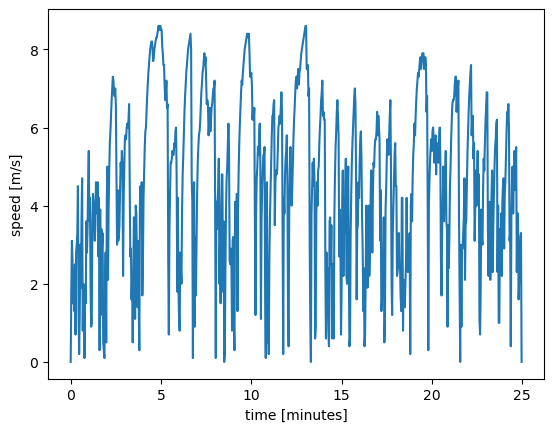

In [31]:
#We can plot the velocity for one of the models like this

plt.plot([k*dt/60 for k in T_idx],list(x_val_dic["H_M"]))
plt.xlabel("time [minutes]")
plt.ylabel("speed [m/s]")

plt.show()

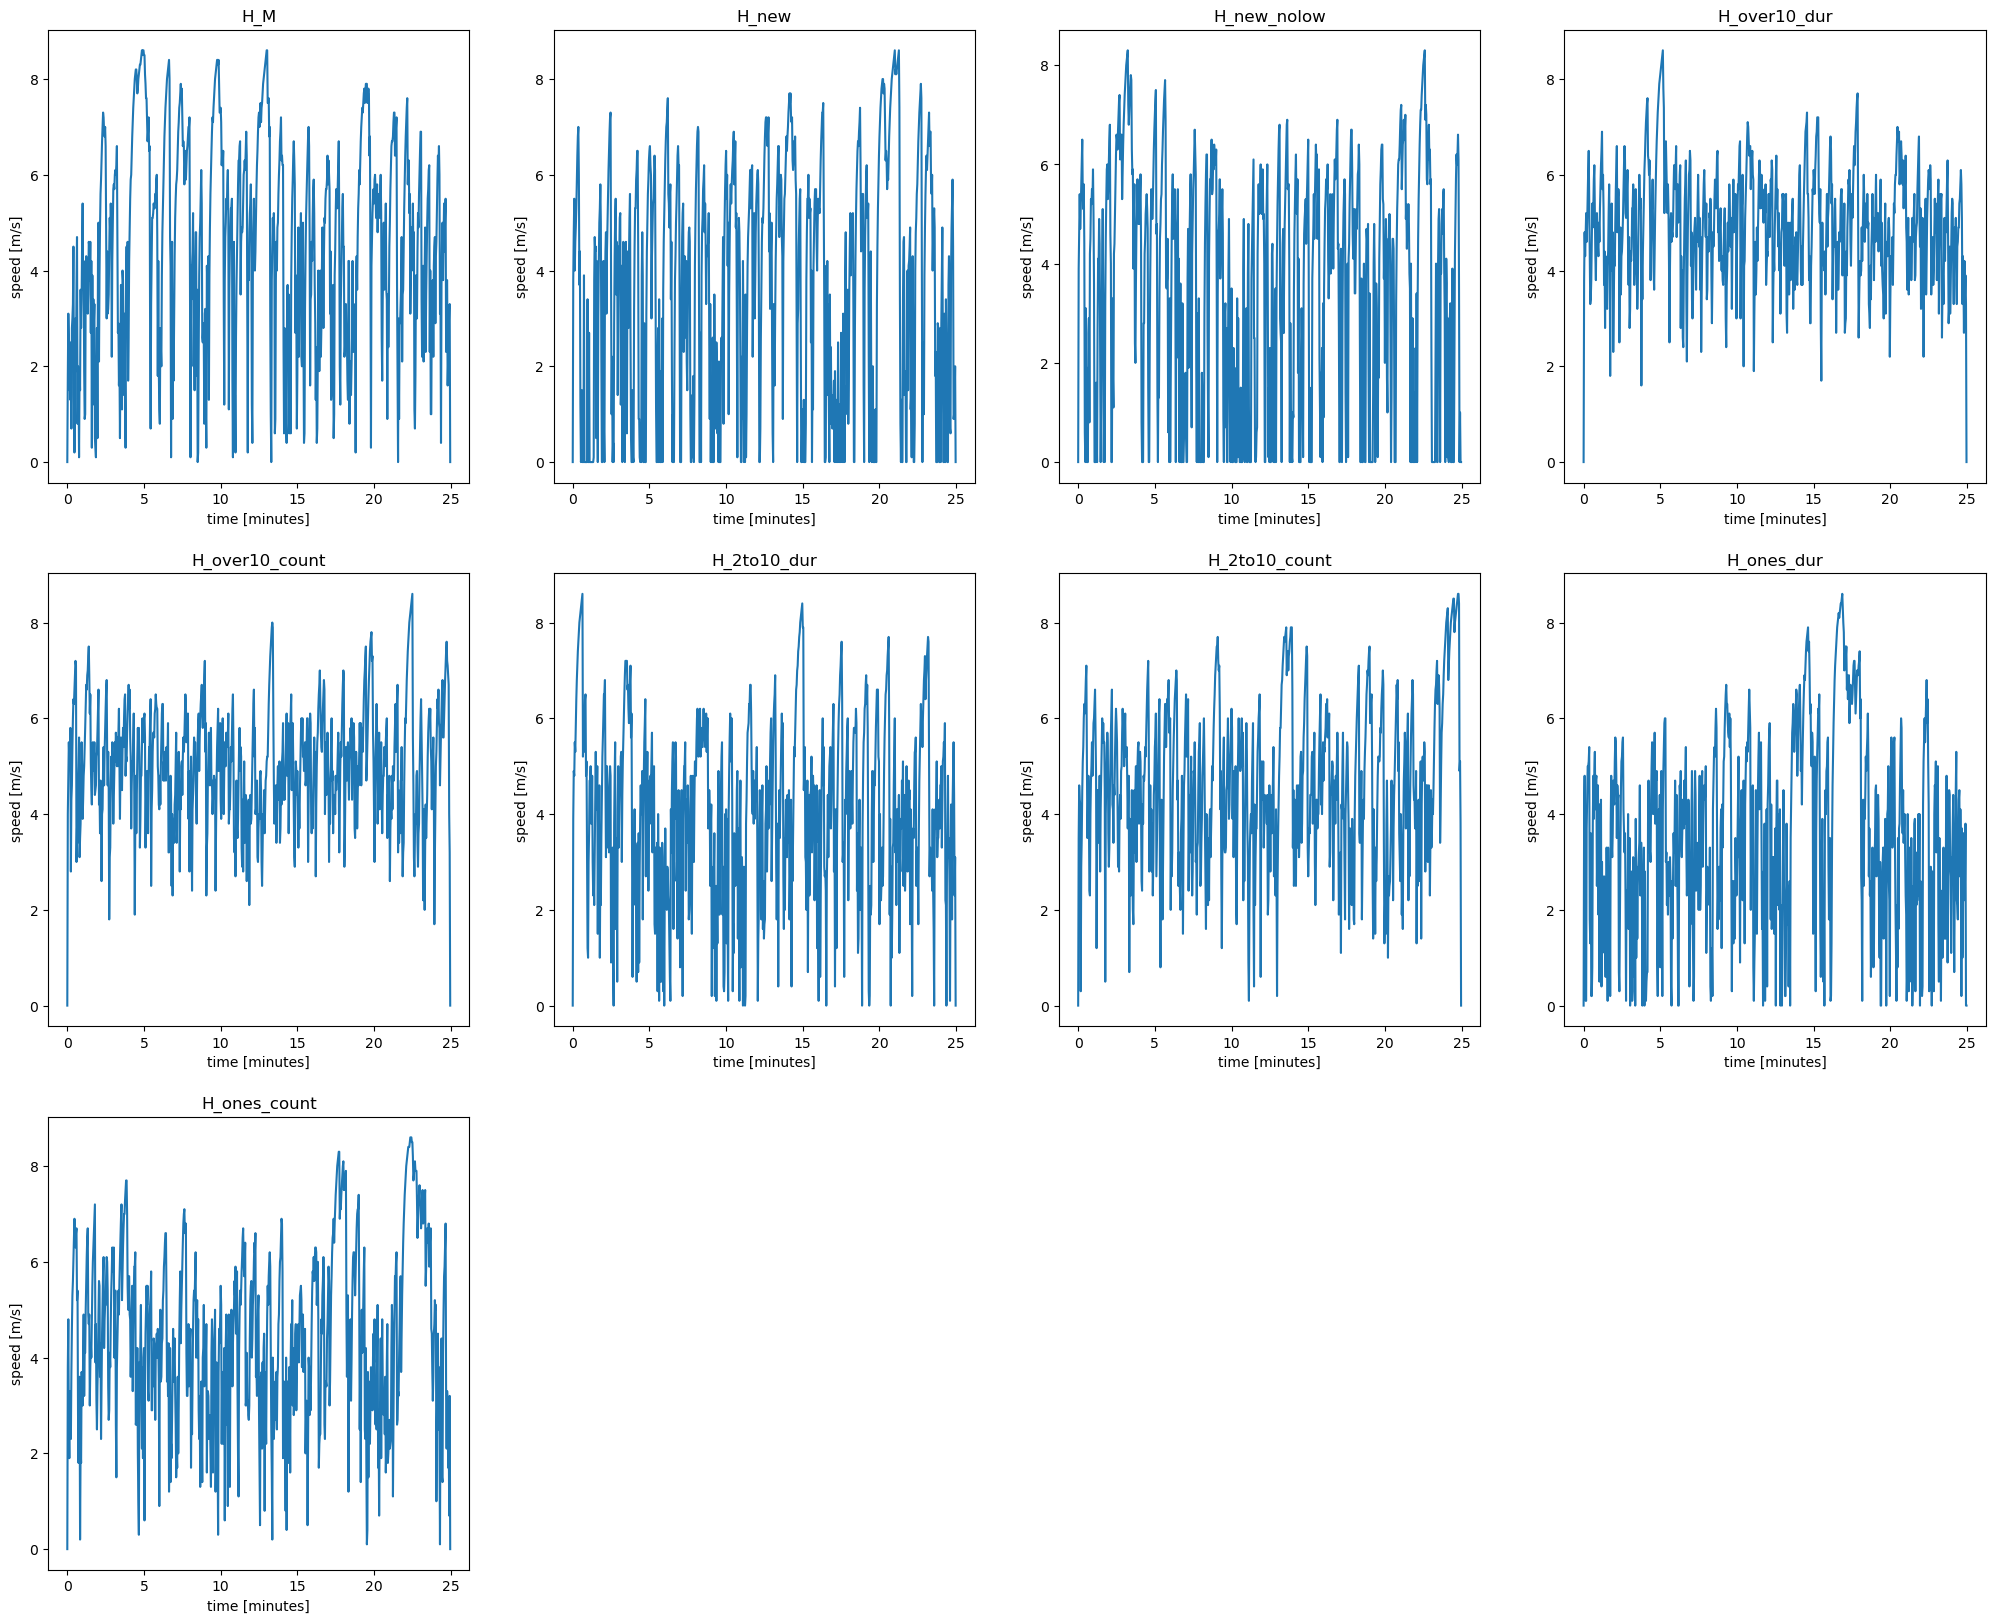

In [7]:
fig = plt.figure(figsize=(25, 20))
i = 0
for key, val in x_val_dic.items():
    i += 1
    plt.subplot(3,4, i)    
    plt.plot([t*2/60 for t in range(750)],val)
    plt.xlabel("time [minutes]")
    plt.ylabel("speed [m/s]")
    plt.title(key)

    
#the x-axis is in m/s * 1/10 (so between 0-9.3 m/s) 
#the reason for this is that the plots look somewhat messy when I choose a different scale on the x-axis 

plt.show()